Multiclass classification with GPflow
--

*Alexander G. de G. Matthews and James Hensman, 2016*

In [13]:
import gpflow
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline

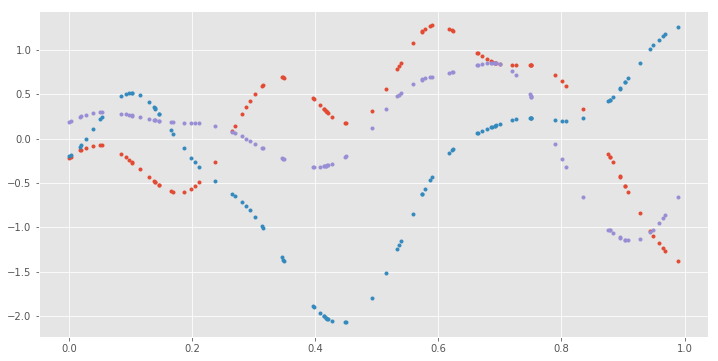

In [14]:
#make a one dimensional classification problem
np.random.seed(1)
X = np.random.rand(100,1)
K = np.exp(-0.5*np.square(X - X.T)/0.01) + np.eye(100)*1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(100,3))

plt.figure(figsize=(12,6))
plt.plot(X, f, '.')

In [15]:
Y = np.array(np.argmax(f, 1).reshape(-1,1), dtype=float)

### Sparse Variational Gaussian approximation

In [16]:
m = gpflow.models.SVGP(
    X, Y, kern=gpflow.kernels.Matern32(1) + gpflow.kernels.White(1, variance=0.01),
    likelihood=gpflow.likelihoods.MultiClass(3),
    Z=X[::5].copy(), num_latent=3, whiten=True, q_diag=True)

m.kern.kernels[1].variance.trainable = False
m.feature.trainable = False
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/kernels/1/variance,Parameter,None,+ve,False,(),True,0.01
SVGP/feature/Z,Parameter,None,(none),False,"(20, 1)",True,"[[0.417022004702574], [0.0923385947687978], [0..."
SVGP/q_mu,Parameter,None,(none),True,"(20, 3)",True,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ..."
SVGP/q_sqrt,Parameter,None,+ve,True,"(20, 3)",True,"[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, ..."


In [17]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.774954
  Number of iterations: 170
  Number of functions evaluations: 201


In [18]:
def plot(m):
    f = plt.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    
    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1,1)
    mu, var = m.predict_f(xx)
    mu, var = mu.copy(), var.copy()
    p, _ = m.predict_y(xx)
    
    a3.set_xticks([])
    a3.set_yticks([])
    
    
    a3.set_xticks([])
    a3.set_yticks([])
    
    for i in range(m.likelihood.num_classes):
        x = m.X.read_value()[m.Y.read_value().flatten()==i]
        points, = a3.plot(x, x*0, '.')
        color=points.get_color()
        a1.plot(xx, mu[:,i], color=color, lw=2)
        a1.plot(xx, mu[:,i] + 2*np.sqrt(var[:,i]), '--', color=color)
        a1.plot(xx, mu[:,i] - 2*np.sqrt(var[:,i]), '--', color=color)
        a2.plot(xx, p[:,i], '-', color=color, lw=2)
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])

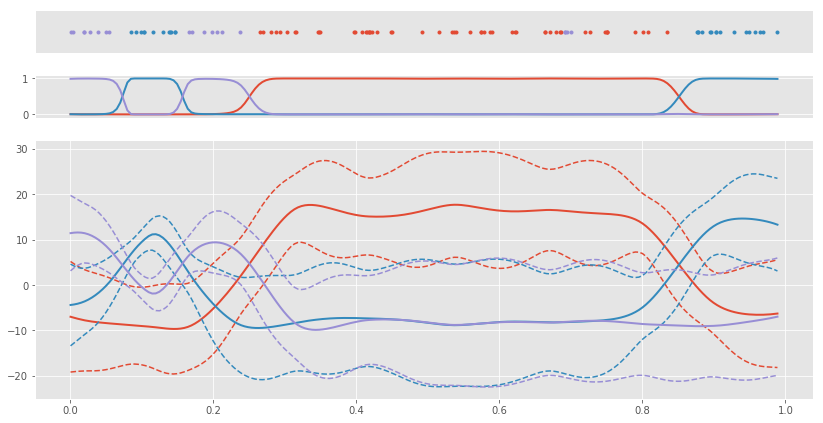

In [19]:
plot(m)

In [20]:
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,80.56199409482296
SVGP/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,0.10404478279057555
SVGP/kern/kernels/1/variance,Parameter,None,+ve,False,(),True,0.01


### Sparse MCMC

In [21]:
with gpflow.defer_build():
    m = gpflow.models.SGPMC(X, Y, 
                     kern=gpflow.kernels.Matern32(1, lengthscales=0.1) + gpflow.kernels.White(1, variance=0.01),
                     likelihood=gpflow.likelihoods.MultiClass(3),
                     Z=X[::5].copy(), num_latent=3)
    m.kern.kernels[0].variance.prior = gpflow.priors.Gamma(1., 1.)
    m.kern.kernels[0].lengthscales.prior = gpflow.priors.Gamma(2., 2.)
    m.kern.kernels[1].variance.trainables = False
    
m.compile()

In [22]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, maxiter=10)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 150.701047
  Number of iterations: 11
  Number of functions evaluations: 14


In [23]:
hmc = gpflow.train.HMC()
samples = hmc.sample(m, num_samples=500, epsilon=0.04, lmax=15, logprobs=False) # verbose=True

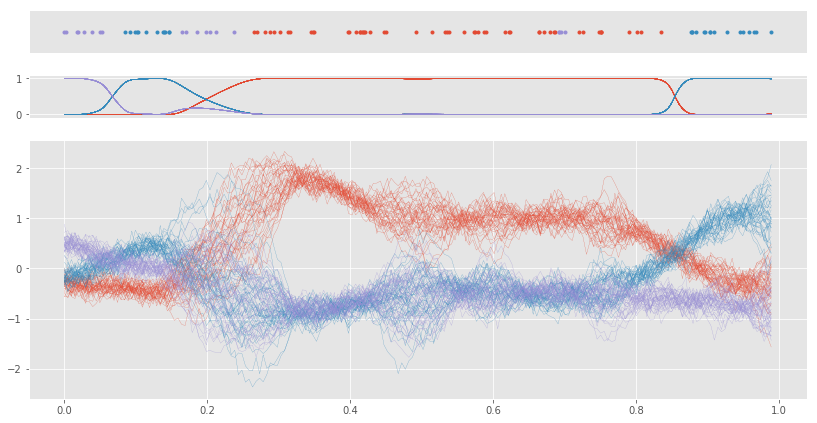

In [24]:
def plot_from_samples(m, samples):
    f = plt.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1,1)
    
    Fpred, Ypred = [], []
    for s in samples[100::10].iterrows(): # burn 100, thin 10
        m.assign(s[1])
        Ypred.append(m.predict_y(xx)[0])
        Fpred.append(m.predict_f_samples(xx, 1).squeeze())

    for i in range(m.likelihood.num_classes):
        x = m.X.read_value()[m.Y.read_value().flatten() == i]
        points, = a3.plot(x, x*0, '.')
        color = points.get_color()
        for F in Fpred:
            a1.plot(xx, F[:,i], color=color, lw=0.2, alpha=1.0)
        for Y in Ypred:
            a2.plot(xx, Y[:,i], color=color, lw=0.5, alpha=1.0)
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])
        
    a3.set_xticks([])
    a3.set_yticks([])
    

plot_from_samples(m, samples)

In [25]:
samples.head()

,SGPMC/V,SGPMC/feature/Z,SGPMC/kern/kernels/0/lengthscales,SGPMC/kern/kernels/0/variance,SGPMC/kern/kernels/1/variance
0,"[[1.7751574107023749, -0.91631471309543, -0.85...","[[0.32825050127995287], [0.12545398029589902],...",0.121302,1.016545,0.009559
1,"[[1.7751574107023749, -0.91631471309543, -0.85...","[[0.32825050127995287], [0.12545398029589902],...",0.121302,1.016545,0.009559
2,"[[1.7751574107023749, -0.91631471309543, -0.85...","[[0.32825050127995287], [0.12545398029589902],...",0.121302,1.016545,0.009559
3,"[[1.7751574107023749, -0.91631471309543, -0.85...","[[0.32825050127995287], [0.12545398029589902],...",0.121302,1.016545,0.009559
4,"[[1.7751574107023749, -0.91631471309543, -0.85...","[[0.32825050127995287], [0.12545398029589902],...",0.121302,1.016545,0.009559


/Users/artemav/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'lengthscale')

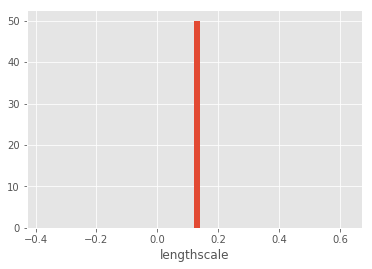

In [26]:
_ = plt.hist(np.vstack(samples['SGPMC/kern/kernels/0/lengthscales']).flatten(), 50, normed=True)
plt.xlabel('lengthscale')